In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

import os
import datetime
import importlib
import sys


#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Finally, import our simulator
from gpuocean.SWEsimulators import CDKLM16, CombinedCDKLM16
from gpuocean.utils import IPythonMagic, Common

In [2]:
%cuda_context_handler gpu_ctx_in

In [3]:
%cuda_context_handler gpu_ctx_out

In [4]:
nx = 50
ny = 70
        
dx = 200.0
dy = 200.0
        
dt = 0.0
g = 9.81
f = 0.0
r = 0.0
    
ghosts = [2,2,2,2] # north, east, south, west
dataShape = (ny + ghosts[0]+ghosts[2], 
                     nx + ghosts[1]+ghosts[3])

T = 600.0

dataRange = [-2, -2, 2, 2]
refRange = dataRange

In [5]:
eta0_in = np.zeros(dataShape, dtype=np.float32)
hu0_in  = np.zeros(dataShape, dtype=np.float32)
hv0_in  = np.zeros(dataShape, dtype=np.float32)

eta0_out = np.zeros(dataShape, dtype=np.float32)
hu0_out  = np.zeros(dataShape, dtype=np.float32)
hv0_out  = np.zeros(dataShape, dtype=np.float32)

Hi_in  = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C') * 10
Hi_out = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C') * 10

bc= Common.BoundaryConditions(3,3,3,3, spongeCells={'north':10, 'south': 10, 'east': 10, 'west': 10})

bc_data_in  = Common.BoundaryConditionsData()
bc_data_in.north.h = [np.array([[1,1]], dtype=np.float32)]

bc_data_out = Common.BoundaryConditionsData()
bc_data_out.north.h = [np.array([[1,1]], dtype=np.float32)] # CHANGED CHANGED!!!

In [6]:
sim_in = CDKLM16.CDKLM16(gpu_ctx_in, eta0_in, hu0_in, hv0_in, Hi_in,\
                                nx, ny, dx, dy, 0.0, g, f, r, \
                                boundary_conditions=bc, boundary_conditions_data=bc_data_in)

sim_out = CDKLM16.CDKLM16(gpu_ctx_out, eta0_out, hu0_out, hv0_out, Hi_out,\
                                nx, ny, dx, dy, 0.0, g, f, r, \
                                boundary_conditions=bc, boundary_conditions_data=bc_data_out)

sims = CombinedCDKLM16.CombinedCDKLM16(sim_in, sim_out)

sims.combinedStep(T)

eta_in2, hu_in2, hv_in2 = sims.barotropic_sim.download(interior_domain_only=True)
eta_out2, hu_out2, hv_out2 = sims.baroclinic_sim.download(interior_domain_only=True)

In [7]:
# Individual sim with in-coming wave
gpu_ctx_in = Common.CUDAContext()

sim_in = CDKLM16.CDKLM16(gpu_ctx_in, eta0_in, hu0_in, hv0_in, Hi_in,\
                                nx, ny, dx, dy, 0.0, g, f, r, \
                                boundary_conditions=bc, boundary_conditions_data=bc_data_in)

sim_in.step(T)

eta_in, hu_in, hv_in = sim_in.download(interior_domain_only=True)

# Individual sim with in-coming wave
gpu_ctx_out = Common.CUDAContext()

sim_out = CDKLM16.CDKLM16(gpu_ctx_out, eta0_out, hu0_out, hv0_out, Hi_out,\
                                nx, ny, dx, dy, 0.0, g, f, r, \
                                boundary_conditions=bc, boundary_conditions_data=bc_data_out)

sim_out.step(T)

eta_out, hu_out, hv_out = sim_out.download(interior_domain_only=True)


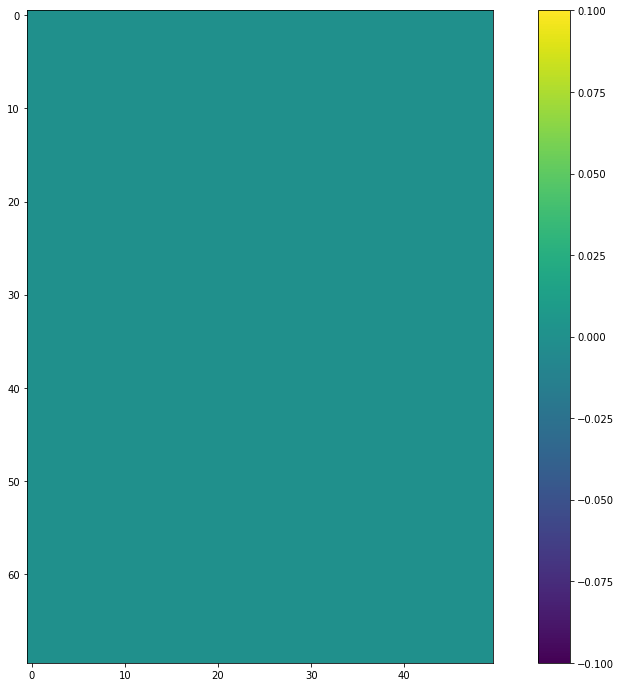

In [8]:
plt.imshow(eta_in - eta_in2)
plt.colorbar()

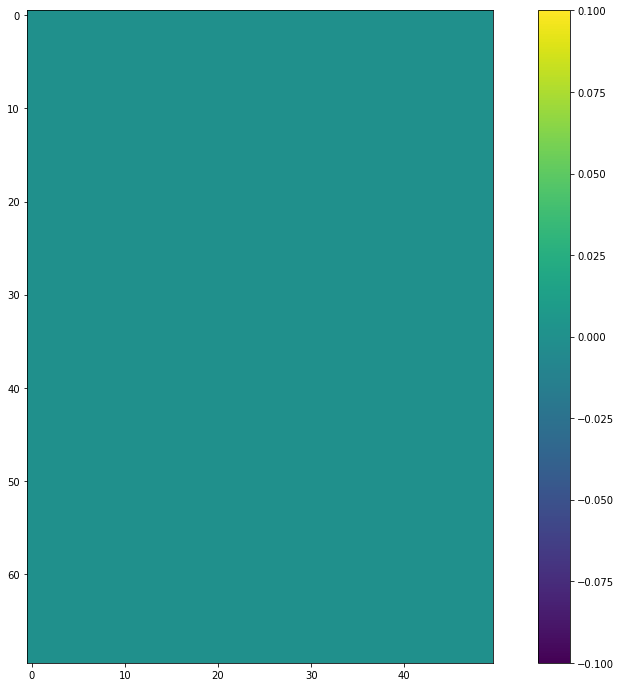

In [9]:
plt.imshow(hv_in - hv_in2)
plt.colorbar()